# Méta Heuristiques - Electif ICO
Nathan Bour, Augustin Carré, Arnaud D'Adhémar, Eliott Daniel, David Marembert, Yoann Remy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

## Modélisation

Nous commençons par définir les paramètres du problème :
- `q` : Capacité maximale de chaque camion.
- `omega` : Coût fixe associé à l'utilisation d'un camion.

In [2]:
q = 400      # Capacité maximale des camions
omega = 10  # Coût fixe par camion utilisé

Une situation du problème (ici récupérée de données réelles) est modélisé par une variable `state` contenant: la positions des clients et du dépôt ainsi que la quantité commandée par chaque client.

Par exemple:

---
```py
state = {
    "position": [
        
        (0, 0),  # Dépôt
        (5, 2),  # Client 1
        (3, -3), # Client 2
        (2, 2),  # Client 3
        # ... autres clients
    ],
    "orders": [0, 5, 10, 7, ...]  # Commandes (0 pour le dépôt)
}
```
---
Les solutions de parcours de livraison sont représenté sous forme de liste.

Par exemple la solution `[0,3,6,0,1,2,0]` signifie qu'un camion va livrer le client 3 puis 6 pendant qu'une autre va a 1 puis 2 (0 correspond au dépot).


Ensuite, nous définissons deux fonctions essentielles :
- `fitness()` : Évalue la qualité d'une solution (plus le score est bas, meilleure est la solution).
- `compute_distance_matrix()` : Calcule les distances entre tous les clients du problème, ce qui évite de recalculer ces distances à chaque itération des algorithmes, **gagnant ainsi drastiquement en performances**.

In [3]:
def fitness(state, solution, distance_matrix):
    orders = state["orders"]

    delivered = set()
    capacity = q
    total_distance = 0
    
    penalty_count = 0  # Count violations instead of returning early
    penalty_factor = 1000  # Base penalty multiplier

    trucks = 0

    for i in range(1, len(solution)):
        prev, curr = solution[i-1], solution[i]
        
        # Check if the path exists
        if distance_matrix[prev, curr] == float("inf"):
            penalty_count += 6  # Path does not exist

        total_distance += distance_matrix[prev, curr]
        
        # If we're at a customer, deliver their order
        if curr != 0:  
            if capacity < orders[curr]:
                penalty_count += (orders[curr] - capacity + 1) // 2  # Not enough capacity
            
            capacity -= orders[curr]
            delivered.add(curr)
        
        # If we're back at the depot, refill the truck
        if curr == 0:
            trucks += 1
            capacity = q

    # Ensure all orders are delivered
    if len(delivered) < len(orders) - 1:  # Excluding depot
        penalty_count += 5 * (len(orders) - 1 - len(delivered))  # Some orders were not delivered

    # Ensure the path starts and ends at the depot
    if solution[0] != 0 or solution[-1] != 0:
        penalty_count += 2  # Route does not start/end at depot

    # Final fitness score: total distance + trucks + penalty
    trucks_value = trucks * omega
    penalty_value = penalty_count * penalty_factor
    return total_distance + trucks_value + penalty_value

In [4]:
def compute_distance_matrix(state):
    coords = state["position"]
    n = len(coords)

    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = np.sqrt((coords[i][0] - coords[j][0])**2 + (coords[i][1] - coords[j][1])**2)
    return dist_matrix

In [5]:
def plot_solution(state, solution):
    plt.figure(figsize=(8, 8))

    # Extraire les coordonnées
    pos = state["position"]

    # Tracer les points
    for i, (x, y) in enumerate(pos):
        if i == 0:
            plt.scatter(x, y, color='black', s=100)  # Point 0 en noir
        else:
            plt.scatter(x, y, color='white', edgecolors='black', s=100)
            #plt.text(x, y, str(i), fontsize=6, color='red')

    # Tracer les lignes pour chaque véhicule
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow']

    # Split solutions by vehicle
    vehicles = []
    current_vehicle = [0]

    for node in solution:
        current_vehicle.append(node)
        if node == 0:
            vehicles.append(current_vehicle)
            current_vehicle = [0]
            
    if current_vehicle:
        vehicles.append(current_vehicle)

    for i, route in enumerate(vehicles):
        for j in range(len(route) - 1):
            (x1, y1), (x2, y2) = pos[route[j]], pos[route[j + 1]]
            plt.plot([x1, x2], [y1, y2], color=colors[i % len(colors)])

    # Affichage du titre et du graphique
    plt.title("Solution")
    plt.axis('off')
    plt.show()

In [6]:
def construct_initial_solution(state):
    """
    Génère une solution initiale en visitant les clients dans l'ordre, avec des retours au dépôt
    lorsque la capacité du camion est atteinte.
    """
    orders = state["orders"]
    solution = [0]  # Commence au dépôt
    current_load = 0

    for client_id in range(1, len(orders)):
        if current_load + orders[client_id] > q:  # Si la capacité est dépassée
            solution.append(0)  # Retour au dépôt
            current_load = 0  # Réinitialiser la charge
        solution.append(client_id)
        current_load += orders[client_id]

    solution.append(0)  # Retour final au dépôt
    return solution

## Chargement de la Base de données

On charge les données d'exemple de notre problème, qui modélisent la situation que nous allons trâiter avec les 3 métaheuristiques.

In [7]:
def load_data(route_id=2946091):
    # Charger les fichiers Excel
    customers_df = pd.read_excel('database/2_detail_table_customers.xls')
    depots_df = pd.read_excel('database/4_detail_table_depots.xls')
    distances_df = pd.read_excel('database/6_detail_table_cust_depots_distances.xls')

    # Filtrer les données pour le ROUTE_ID spécifié
    customers_df = customers_df[customers_df['ROUTE_ID'] == route_id]
    depots_df = depots_df[depots_df['ROUTE_ID'] == route_id]
    distances_df = distances_df[distances_df['ROUTE_ID'] == route_id]

    # Extraire les informations des clients
    customer_positions = list(zip(customers_df['CUSTOMER_LATITUDE'], customers_df['CUSTOMER_LONGITUDE']))
    orders = list(map(int, customers_df['NUMBER_OF_ARTICLES']))

    # Extraire les informations des dépôts
    depot_positions = list(zip(depots_df['DEPOT_LATITUDE'], depots_df['DEPOT_LONGITUDE']))

    # Extraire les distances
    distances = {}
    for _, row in distances_df.iterrows():
        key = (row['DEPOT_CODE'], row['CUSTOMER_CODE'])
        distances[key] = row['DISTANCE_KM']

    # Créer la structure de données
    state = {
        "position": [depot_positions[0]] + customer_positions,  # Ajouter le dépôt en premier
        "orders": [0] + orders  # La demande du dépôt est 0
    }

    return state #, distances

In [8]:
state = load_data()
distance_matrix = compute_distance_matrix(state)
initial_solution = construct_initial_solution(state)

In [9]:
initial_cost = fitness(state, initial_solution, distance_matrix)
print("Solution initiale:", initial_solution)
print(f"Coût de la solution initiale: {initial_cost:.3f}")

Solution initiale: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 0, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 0, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 0, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 0, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 0]
Coût de la solution initiale: 88.431


## 1) Algorithme Tabou

### Explication de la Fonction `tabu_search`:
La fonction `tabu_search` implémente l'algorithme de recherche tabou.

L'algorithme de recherche tabou explore l'espace des solutions pour trouver une solution optimale (ou proche de l'optimum) en évitant de rester bloqué dans des optima locaux. Pour cela, il utilise une liste tabou qui interdit temporairement certains mouvements déjà explorés.

#### Paramètres
`state` : l'état du problème

`initial_solution` : Une solution initiale à partir de laquelle l'algorithme commence sa recherche.

`max_iter` : Le nombre maximal d'itérations de l'algorithme (par défaut : 100).

`tabu_tenure` : La durée pendant laquelle un mouvement reste dans la liste tabou (par défaut : 5).

`neighborhood_size` : Le nombre de voisins générés à chaque itération (par défaut : 20).

#### Fonctionnement

Initialisation :

La meilleure solution est initialisée avec la solution initiale.

La liste tabou est vide.

Exploration du voisinage :

À chaque itération, l'algorithme génère un ensemble de voisins en modifiant légèrement la solution actuelle (par exemple, en échangeant deux clients dans la tournée).

Seuls les voisins valides (respectant les contraintes du problème) sont conservés.

Sélection du meilleur voisin :

Le meilleur voisin (celui avec le coût le plus bas) est sélectionné.

Si ce voisin n'est pas dans la liste tabou (ou s'il est meilleur que la meilleure solution trouvée jusqu'à présent), il devient la nouvelle solution courante.

Mise à jour de la liste tabou :

Le mouvement utilisé pour générer le nouveau voisin est ajouté à la liste tabou.

Si la liste tabou dépasse sa taille maximale, le mouvement le plus ancien est supprimé.

Critère d'arrêt :

L'algorithme s'arrête après `max_iter itérations` ou si aucun voisin valide n'est trouvé.

#### Résultat
La fonction retourne la meilleure solution trouvée et son coût associé.

In [11]:
def tabu_search(state, initial_solution, max_iter=100, tabu_tenure=5, neighborhood_size=20):
    distance_matrix = compute_distance_matrix(state)
    best_solution = initial_solution
    best_cost = fitness(state, best_solution, distance_matrix)
    tabu_list = []
    
    for iteration in range(max_iter):
        neighborhood = []

        # Générer un sous-ensemble de voisins avec des swaps
        for _ in range(neighborhood_size):
            i, j = random.sample(range(1, len(best_solution) - 1), 2)  # Choisir 2 clients aléatoires
            new_solution = best_solution[:]
            new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
            
            cost = fitness(state, new_solution, distance_matrix)
            move = (i, j)
            neighborhood.append((new_solution, cost, move))
        
        if not neighborhood:
            break

        # Trier les voisins par coût
        neighborhood.sort(key=lambda x: x[1])

        for candidate, cost, move in neighborhood:
            if move not in tabu_list or cost < best_cost:
                best_solution = candidate
                best_cost = cost
                tabu_list.append(move)
                
                if len(tabu_list) > tabu_tenure:
                    tabu_list.pop(0)

                if cost < best_cost:
                    best_cost = cost
                    tabu_list = []  # Réinitialisation de la liste tabou si une meilleure solution est trouvée
                break
    
    return best_solution, best_cost

### Test de l'Algorithme Tabou

In [33]:
optimized_solution, min_cost = tabu_search(state, initial_solution, max_iter=500, tabu_tenure=20)

print("Solution optimisée:", optimized_solution)
print(f"Coût optimisé: {min_cost:.3f}")

Solution optimisée: [0, 14, 6, 47, 52, 21, 98, 48, 7, 85, 18, 84, 58, 39, 74, 8, 88, 79, 10, 27, 86, 0, 104, 106, 64, 32, 53, 75, 30, 95, 107, 3, 23, 87, 28, 54, 55, 91, 57, 89, 40, 2, 70, 41, 5, 99, 69, 25, 16, 46, 0, 78, 29, 15, 35, 96, 37, 81, 82, 66, 24, 93, 68, 1, 61, 42, 20, 94, 9, 60, 65, 0, 97, 90, 71, 73, 19, 33, 4, 31, 77, 50, 44, 63, 36, 103, 12, 83, 56, 67, 0, 59, 72, 17, 49, 38, 80, 62, 101, 45, 100, 13, 11, 22, 43, 105, 34, 92, 51, 76, 26, 102, 0]
Coût optimisé: 62.104


### Visualisation de la solution optimisée

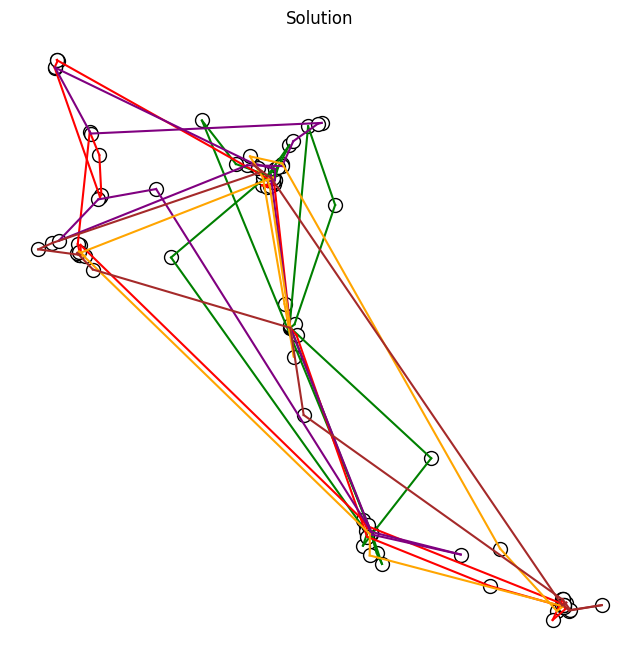

In [34]:
plot_solution(state, optimized_solution)

## 2) Algorithme du Recuit Simulé

### Explication de l'algorithme

Le recuit simulé fonctionne en explorant l'espace des solutions de manière itérative. Il commence avec une solution initiale et tente de l'améliorer en effectuant des modifications aléatoires. L'algorithme accepte parfois des solutions moins optimales pour éviter de se coincer dans des optimums locaux, ce qui permet d'explorer plus largement l'espace des solutions.

In [18]:
def mutate(solution):
    new_solution = solution.copy()

    if random.random() < 0.8:
        # Swap two random points
        i, j = random.sample(range(0, len(new_solution)), 2)
        new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
    elif random.random() < 0.5:
        # Add a 0 somewhere in the middle
        i = random.randint(1, len(new_solution) - 1)
        new_solution.insert(i, 0)
    else:
        zero_indices = [i for i, val in enumerate(new_solution) if val == 0]
        if zero_indices:  # Ensure there's at least one 0
            random_index = random.choice(zero_indices)  # Pick a random 0 index
            del new_solution[random_index]

    return new_solution

In [19]:
def RS(state, initial_solution, distance_matrix, iterations=200, T = 1000, T_min = 0.1, alpha = 0.99):
    # Initialisation
    current_solution = initial_solution.copy()
    current_fitness = fitness(state, current_solution, distance_matrix)
    
    best_solution = current_solution.copy()
    best_fitness = current_fitness
    
    # Exécution du recuit simulé
    while T > T_min:
        for _ in range(iterations):
            new_solution = mutate(current_solution)
            new_fitness = fitness(state, new_solution, distance_matrix)
            
            # Si la nouvelle solution est meilleure, l'accepter
            if new_fitness < current_fitness:
                current_solution = new_solution
                current_fitness = new_fitness

                # Mettre à jour la meilleure solution
                if current_fitness < best_fitness:
                    best_solution = current_solution.copy()
                    best_fitness = current_fitness
            # Sinon, l'accepter avec une certaine probabilité
            else:
                delta = new_fitness - current_fitness
                probability = np.exp(-delta / T)
                if random.random() < probability:
                    current_solution = new_solution
                    current_fitness = new_fitness
        
        T *= alpha  # Réduire la température

    return best_solution, best_fitness

### Test de l'Algorithme du Recuit Simulé

In [25]:
optimized_solution, min_cost = RS(state, initial_solution, distance_matrix)

print("Solution optimisée:", optimized_solution)
print(f"Coût optimisé: {min_cost:.3f}")

Solution optimisée: [0, 93, 18, 56, 9, 16, 40, 61, 57, 70, 99, 54, 102, 23, 15, 100, 11, 30, 95, 22, 51, 47, 14, 43, 92, 105, 13, 88, 50, 35, 106, 29, 31, 32, 4, 3, 52, 63, 55, 0, 37, 21, 27, 1, 58, 59, 12, 69, 84, 72, 44, 38, 2, 28, 0, 86, 42, 41, 5, 36, 98, 68, 24, 90, 103, 82, 81, 89, 66, 71, 80, 20, 101, 60, 25, 0, 7, 85, 62, 94, 79, 97, 46, 83, 73, 0, 87, 74, 78, 33, 107, 76, 26, 53, 34, 75, 64, 6, 77, 8, 39, 96, 65, 67, 10, 45, 48, 19, 91, 49, 17, 104, 0]
Coût optimisé: 62.079


### Visualisation de la solution optimisée

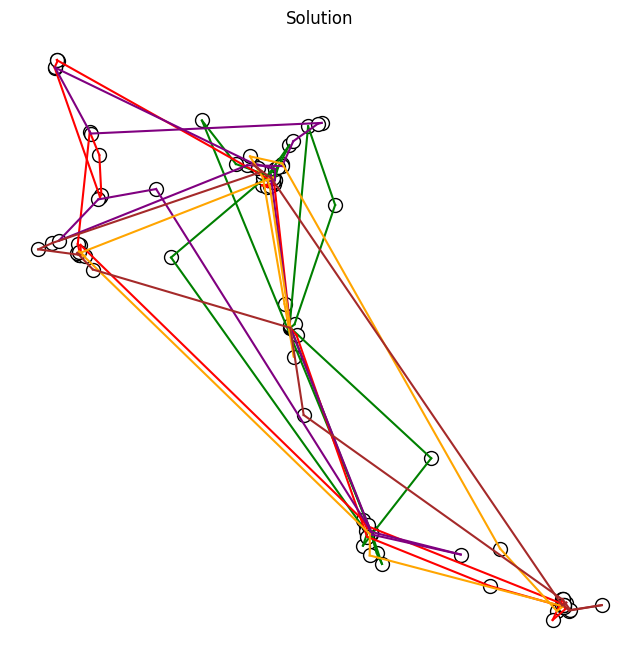

In [35]:
plot_solution(state, optimized_solution)

### Comparaison des paramètres

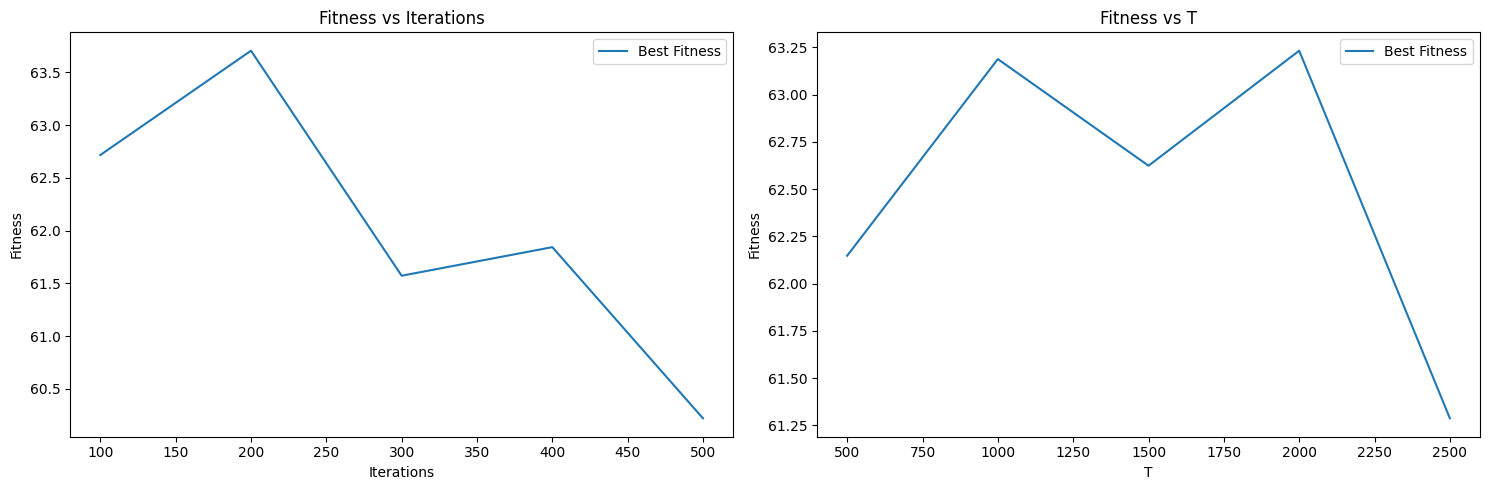

In [38]:
# Plages de valeurs pour les paramètres
iterations_values = [100, 200, 300, 400, 500]
T_values = [500, 1000, 1500, 2000, 2500]

# Paramètres constants
fixed_iterations = 200
fixed_T = 1000
T_min = 0.1
alpha = 0.99

# Tester les itérations
fitness_over_iterations = []
for iterations in iterations_values:
    best_solution, best_fitness = RS(state, initial_solution, distance_matrix, iterations, fixed_T, T_min, alpha)
    fitness_over_iterations.append((iterations, best_fitness))

# Tester T
fitness_over_T = []
for T in T_values:
    best_solution, best_fitness = RS(state, initial_solution, distance_matrix, fixed_iterations, T, T_min, alpha)
    fitness_over_T.append((T, best_fitness))

# Tracer les graphiques
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Graphique 1: Fitness vs Iterations
iterations, fitness_values = zip(*fitness_over_iterations)
axs[0].plot(iterations, fitness_values, label='Best Fitness')
axs[0].set_title('Fitness vs Iterations')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Fitness')
axs[0].legend()

# Graphique 2: Fitness vs T
T_values, fitness_values = zip(*fitness_over_T)
axs[1].plot(T_values, fitness_values, label='Best Fitness')
axs[1].set_title('Fitness vs T')
axs[1].set_xlabel('T')
axs[1].set_ylabel('Fitness')
axs[1].legend()
plt.tight_layout()
plt.show()

# 3) **Algorithme Génétique (Yoann REMY et Nathan BOUR)**

Les algorithmes génétiques (AG) sont des techniques d'optimisation inspirées du processus de sélection naturelle. Leur objectif est de trouver une solution optimale ou quasi-optimale à un problème en simulant l'évolution des espèces.

Ils fonctionnent avec une population de solutions candidates (appelées individus), qui évoluent au fil des générations grâce à des opérateurs génétiques :

* Sélection : Choisir les meilleurs individus selon une fonction d’évaluation.
* Croisement (crossover) : Combiner deux individus pour créer une nouvelle solution.
* Mutation : Modifier légèrement une solution pour introduire de la diversité.

C'est ce que nous allons implémenter pour cette dernière méta-heuristique

In [10]:
ELITISM = 15 # Nombre de solutions retenues pour la prochaine génération

## Explication de la fonction `crossover`

La fonction `crossover` génère un nouvel individu (enfant) à partir de deux parents en respectant les contraintes du problème. Elle fonctionne en plusieurs étapes :

### 1. Sélection d’une portion du premier parent  
- Deux indices aléatoires sont choisis pour délimiter une sous-partie de `parent1`.  
- Cette portion est directement copiée dans l’enfant.  

### 2. Remplissage avec le second parent  
- Les emplacements vides sont complétés avec `parent2`, en évitant les doublons.  
- Si un gène est déjà présent dans l’enfant, on cherche un autre gène disponible dans `parent2`.  
- Si aucun gène valide n’est trouvé, on arrête l’exécution (évite les boucles infinies).  

### 3. Correction des clients manquants  
- On vérifie que tous les clients sont présents dans l’enfant.  
- Si un client manque, on remplace un dépôt intermédiaire (`0`) par ce client (dépot choisi aléatoirement parmi ceux qui ne sont pas le début et la fin)  

### 4. Retour d'un nouvel individu  
- L’enfant généré respecte les contraintes :  
  - Tous les clients sont visités une seule fois.  
  - Les dépôts (`0`) restent présents pour les retours.  
- Il représente une nouvelle solution valide, combinant les caractéristiques des deux parents. 


In [11]:
def crossover(parent1, parent2, nb_clients):
    size = min(len(parent1), len(parent2))

    # Choisir deux indices de croisement aléatoires, sans toucher au premier et dernier élément
    start, end = sorted(random.sample(range(1, size - 1), 2))

    # Initialiser l'enfant avec des valeurs -1 (indiquant des positions vides)
    child = [-1] * size

    # Copier la portion de parent1 entre les indices start et end dans l'enfant
    child[start:end] = parent1[start:end]

    # Fonction pour savoir si un gène existe déjà dans l'enfant (à l'exception de 0)
    def is_present(gene, child, start, end):
        return gene != 0 and gene in child

    # Remplir les cases vides de l'enfant avec les gènes de parent2
    current_pos = 0
    for i in range(size):
        if child[i] == -1:
            gene = parent2[i]

            # Si le gène est déjà présent dans la portion copiée, on doit le remplacer
            while is_present(gene, child, start, end) and gene != 0:
                current_pos += 1
                gene = parent2[current_pos]
                # Si on revient à la position de départ, on arrête pour éviter boucle infinie
                if current_pos == size:
                    print("FATAL")
                    exit()
                    break

            # Affecter le gène dans la position vide
            child[i] = gene

    for i in range(nb_clients):
        zeroes = [j for j in range(len(child[1:-1])) if child[j]==0]
        if not i in child:
            if zeroes != []:
                selected_zero = random.randint(0,len(zeroes)-1)
                child[zeroes[selected_zero]] = i 

    return child

# Explication des fonctions de mutation

Les fonctions `swap_mutation` et `inversion_mutation` introduisent des modifications aléatoires dans une solution pour diversifier la population et éviter la convergence prématurée. Nous avons voulu en implémenter 2 différentes pour voir ce que cela donnerait

### 1. `swap_mutation(solution, mutation_rate)`
Cette mutation échange deux éléments aléatoires de la solution.  

### Étapes :
1. Avec une probabilité égale à `mutation_rate`, la mutation est appliquée.  
2. Deux indices distincts sont sélectionnés aléatoirement (hors dépôt).  
3. Les valeurs de ces deux indices sont échangées.  

### Objectif :
- Modifier légèrement la solution tout en conservant sa structure.
- Introduire de la diversité pour éviter de rester bloqué dans un optimum local.


### 2. `inversion_mutation(solution, mutation_rate)`
Cette mutation inverse l'ordre des éléments d’une sous-section aléatoire de la solution.  

### Étapes :
1. Avec une probabilité égale à `mutation_rate`, la mutation est appliquée.  
2. Deux indices sont sélectionnés pour définir une sous-section de la solution.  
3. L'ordre des éléments de cette sous-section est inversé.  

### Objectif :
- Modifier des segments entiers pour explorer de nouvelles configurations.  
- Préserver les relations locales entre les clients tout en générant de nouvelles solutions.  

Ces deux mutations permettent de perturber légèrement la solution pour explorer plus efficacement l’espace de recherche tout en respectant les contraintes du problème.


In [12]:
def swap_mutation(solution, mutation_rate):
    if random.random() < mutation_rate:
        idx1, idx2 = random.sample(range(1, len(solution) - 1), 2)
        solution[idx1], solution[idx2] = solution[idx2], solution[idx1]
    return solution

def inversion_mutation(solution, mutation_rate):
    if random.random() < mutation_rate:
        start, end = sorted(random.sample(range(1, len(solution) - 1), 2))
        solution[start:end] = solution[start:end][::-1]
    return solution

# Explication des fonctions de sélection

Les fonctions `tournament_selection` et `roulette_selection` permettent de sélectionner des individus dans une population en fonction de leur performance (fitness).  Nous avons choisi d'en implementer deux également.

### 1. `tournament_selection(population, fitness_values, tournament_size=5)`
Cette méthode sélectionne le meilleur individu parmi un sous-groupe aléatoire.  

### Étapes :
1. Sélection aléatoire de `tournament_size` individus dans la population.  
2. Comparaison de leur valeur de fitness.  
3. Retour de l’individu avec la meilleure fitness** (minimisation du coût).  

### Objectif :
- Favoriser les meilleures solutions tout en gardant une part de hasard.  
- Éviter une sélection trop stricte qui réduirait la diversité.  


### 2. `roulette_selection(population, fitness_values)`
Cette méthode attribue une probabilité de sélection inversement proportionnelle à la fitness (plus une solution est mauvaise, moins elle a de chances d’être choisie).  

### Étapes :
1. Calcul des probabilités de sélection en inversant la fitness (ajout de `1e-6` pour éviter la division par zéro).  
2. Choix d’un individu en fonction de ces probabilités (tirage aléatoire pondéré).  

### Objectif :
- Favoriser les meilleures solutions tout en laissant une chance aux autres.  
- Introduire plus de variabilité que la sélection par tournoi.  

Ces deux méthodes influencent l’évolution de la population en sélectionnant les individus qui vont être croisés et mutés pour la génération suivante.  


In [13]:
def tournament_selection(population, fitness_values, tournament_size=5):
    tournament_indices = random.sample(range(len(population)), tournament_size)
    best_idx = min(tournament_indices, key=lambda i: fitness_values[i])
    return population[best_idx]

def roulette_selection(population, fitness_values):
    inverse_fitness = 1 / (np.array(fitness_values) + 1e-6)
    probabilities = inverse_fitness / np.sum(inverse_fitness)
    return population[np.random.choice(len(population), p=probabilities)]

# Explication de la fonction `genetic_algorithm`

Cette fonction exécute un algorithme génétique pour résoudre un problème d’optimisation basé sur un état initial et une population de solutions.


### 1. **Initialisation**
- Calcul de la matrice de distances entre les clients.  
- Évaluation de la fitness de chaque individu dans la population.  
- Stockage de la meilleure solution trouvée au départ.  

### 2. **Boucle principale (évolution sur plusieurs générations)**
- Tri de la population selon la fitness (les meilleures solutions en premier).  
- Conservation de l’élite (`ELITISM`) pour éviter la perte des meilleures solutions.  
- À certaines générations (`generations_list`), sauvegarde des meilleures solutions.  

### 3. **Création d’une nouvelle population**
- Sélection de deux parents via tournoi ou roulette.  
- Croisement des parents pour générer un enfant.  
- Mutation de l’enfant avec la méthode choisie (`swap` ou `inversion`).  
- Ajout de l’enfant à la nouvelle population s’il est unique.  
- Mise à jour de la meilleure solution trouvée si l’enfant est meilleur.  

### 4. **Retour des résultats**
- Renvoie les meilleures solutions et leurs valeurs de fitness enregistrées au fil des générations.  

### Objectif
L’algorithme optimise progressivement la population en sélectionnant, croisant et mutant les solutions pour trouver une tournée optimale en minimisant la distance parcourue.   


In [14]:
def genetic_algorithm(state, population, population_size, generations_list, mutation_rate, selection_method='tournament', mutation_method='swap'):
    global MUTATION_RATE
    MUTATION_RATE = mutation_rate

    distance_matrix = compute_distance_matrix(state)
    #population = [create_initial_solution(state) for _ in range(population_size)]
    fitness_values = np.array([fitness(state, sol, distance_matrix) for sol in population])

    best_solution = population[np.argmin(fitness_values)]
    best_fitness = min(fitness_values)
    

    best_solutions = []
    best_fitnesss = []

    for generation in range(generations_list[-1]):
        sorted_indices = np.argsort(fitness_values)
        population = [population[i] for i in sorted_indices]
        fitness_values = fitness_values[sorted_indices]

        new_population = population[:ELITISM]
        new_fitness_values = list(fitness_values[:ELITISM])
        
        if generation+1 in generations_list:
            best_solutions.append(new_population[0])
            best_fitnesss.append(new_fitness_values[0])

        while len(new_population) < population_size:
            #print(len(new_population))
            parent1 = tournament_selection(population, fitness_values) if selection_method == 'tournament' else roulette_selection(population, fitness_values)
            parent2 = tournament_selection(population, fitness_values) if selection_method == 'tournament' else roulette_selection(population, fitness_values)

            child = crossover(parent1, parent2, len(state["orders"]))
            prev_fitness = fitness(state, child, distance_matrix)
          
            child = swap_mutation(child, mutation_rate) if mutation_method == 'swap' else inversion_mutation(child, mutation_rate)
            child_fitness = fitness(state, child, distance_matrix)

            if child not in new_population:
                new_population.append(child)
                new_fitness_values.append(child_fitness)

            if child_fitness < best_fitness:
                #print("AMELIORATION !!!", child_fitness)
                best_solution = child
                best_fitness = child_fitness

        population = new_population
        fitness_values = np.array(new_fitness_values)

    return best_solutions, best_fitnesss

# **Influence des différents paramètres sur la fitness**
Nous allons maintenant pouvoir observer ce qu'il se passe lorsque l'on modifie certains paramètres comme :
* Le nombre de **générations**
* La taille de la **population**
* Le taux de **mutation**

Nous allons faire varier les valeurs de ces paramètres et comparer la **fitness**

## 1) Impact du nombre de générations


[86.51611722144006, 85.53815499089842, 83.28753128987998, 78.45142336247234, 75.90099694488477, 73.7674152039816, 71.59113750120643, 66.58037188433437, 63.29891239878685, 60.969764614639374, 60.10803169467954]
[5, 10, 20, 40, 60, 80, 100, 200, 400, 1000, 2000]


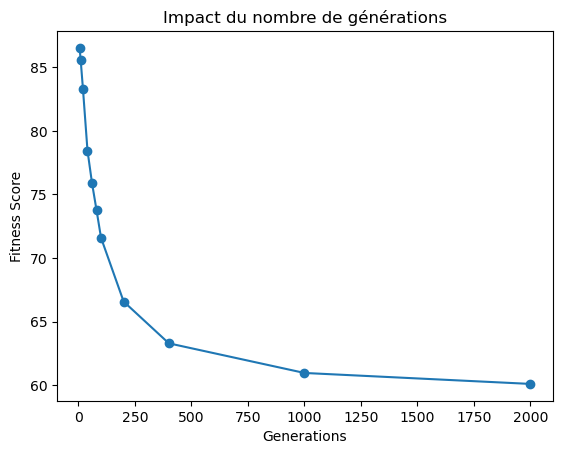

In [24]:
# Impact du nombre de générations

generations_list = [5, 10, 20, 40, 60, 80, 100, 200, 400, 1000, 2000]

fitness_results = []
population_size = 40
mutation_rate = 0.3
population = [construct_initial_solution(state) for _ in range(population_size)]

best_solutions, fitness_results = genetic_algorithm(state, population, population_size, generations_list, mutation_rate)
print()
print(fitness_results)
print(generations_list)

plt.plot(generations_list, fitness_results, marker='o')
plt.title("Impact du nombre de générations")
plt.xlabel("Generations")
plt.ylabel("Fitness Score")
plt.show()

On observe clairement une décroissance de la fitness lorsque le nombre de générations augmente. Cela est cohérent car plus on a de générations, plus on a de chance de créer des individus qui seront meilleurs.

## 2) Impact de la taille de la population

5 fait
8 fait
10 fait
15 fait
20 fait
40 fait
60 fait


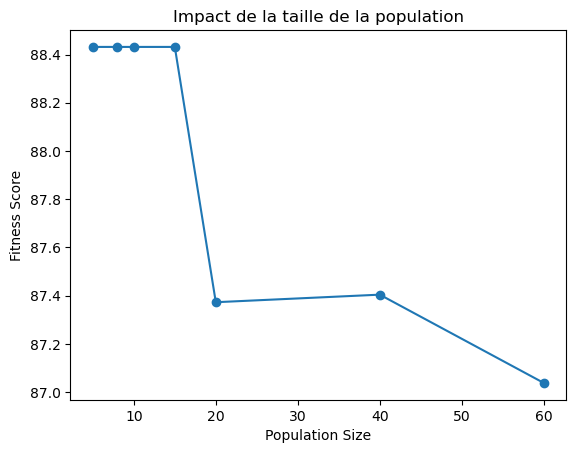

In [25]:
# Impact de la taille de la population

population_sizes = [5, 8, 10, 15, 20, 40, 60]

generations = [100]
mutation_rate = 0.3
fitness_results = []
for population_size in population_sizes:
    population = [construct_initial_solution(state) for _ in range(population_size)]
    best_solution, best_fitness = genetic_algorithm(state, population, population_size, generations_list, mutation_rate)
    fitness_results.append(best_fitness[0])
    print((population_size), 'fait')
plt.plot(population_sizes, fitness_results, marker='o')
plt.title("Impact de la taille de la population")
plt.xlabel("Population Size")
plt.ylabel("Fitness Score")
plt.show()

5 fait
8 fait
10 fait
15 fait
20 fait
30 fait
40 fait
60 fait
100 fait


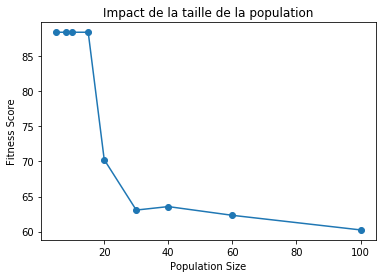

In [16]:
# Impact de la taille de la population

population_sizes = [5, 8, 10, 15, 20, 30, 40, 60, 100]

generations = [800]
mutation_rate = 0.3
fitness_results = []
for population_size in population_sizes:
    population = [construct_initial_solution(state) for _ in range(population_size)]
    best_solution, best_fitness = genetic_algorithm(state, population, population_size, generations_list, mutation_rate)
    fitness_results.append(best_fitness[0])
    print((population_size), 'fait')
plt.plot(population_sizes, fitness_results, marker='o')
plt.title("Impact de la taille de la population")
plt.xlabel("Population Size")
plt.ylabel("Fitness Score")
plt.show()

Idem, on observe qu'une population plus grande (et donc plus diversifiée) aboutit à des individus (solutions) de meilleur qualité

## 3) Impact du taux de mutation

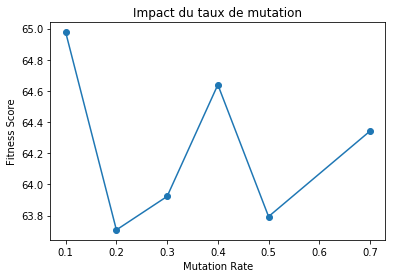

In [15]:
# Impact du taux de mutation

mutation_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]

fitness_results = []
population_size = 40
generations_list = [500]
population = [construct_initial_solution(state) for _ in range(population_size)]

for mutation_rate in mutation_rates:
    best_solution, best_fitness = genetic_algorithm(state, population, population_size, generations_list, mutation_rate)
    fitness_results.append(best_fitness[0])
plt.plot(mutation_rates, fitness_results, marker='o')
plt.title("Impact du taux de mutation")
plt.xlabel("Mutation Rate")
plt.ylabel("Fitness Score")
plt.show()

Ici on constate que dans la plupart des situations (si on lance plusieurs fois la simulation) le minimum se trouve aux alentours de 0.2, ce qui correspond à une probabilité de mutation de 20%. Cela parait cohérent, car la mutation est assez peu fréquente pour ne pas détruire une population dotée d'un grand nombre de bons individus, mais à la fois assez fréquente (1 fois sur 5) pour permettre de diversifier la population lorsque les individus commencent à se ressembler (minimum local)

In [19]:
test_state = load_data()

print(len(test_state['orders']))
print(len(test_state['position']))

108
108


In [21]:
print(test_state)

{'position': [(43.37391833, 17.60171712), (43.41305, 17.87588), (43.135963, 17.776839), (43.46907801, 17.33702249), (43.70716, 17.2229), (43.08222786, 17.96003741), (43.46470189, 17.31043644), (43.35266, 17.80444), (43.48189308, 17.30045863), (43.35459, 17.79902), (43.396088, 17.871369), (43.71657, 17.23185), (43.11036, 17.70165), (43.71619, 17.2317), (43.54998018, 17.42732548), (43.475001, 17.325417), (43.33841, 17.79242), (43.111171, 17.69928539), (43.34568, 17.80545), (43.36378, 17.82157), (43.32605, 17.82229), (43.224819, 17.695885), (43.71695937, 17.23264032), (43.46991226, 17.3333838), (43.36369616, 17.8181746), (43.34521, 17.7901), (43.71342, 17.23878), (43.429906, 17.7661), (43.11155, 17.71267), (43.586910367012, 17.298542261123), (43.71763, 17.22673), (43.71489, 17.22924), (43.71959, 17.22727), (43.63608, 17.30644), (43.72212, 17.22354), (43.4744, 17.32819), (43.10913847, 17.69950533), (43.20614682, 17.78742814), (43.07658527, 17.71537328), (43.47523786, 17.32810521), (43.1377

# **Recherche de la meilleure solution**
Fort des observations précédentes de l'impact des paramètres nous pouvons tenter de trouver la meilleure solution dans un temps de calcul raisonable. Nous prenons donc d'après nos observations les paramètres suivants :

In [ ]:
population_size = 120
generations = 2500
mutation_rate = 0.2

Etant donné que nous avons implémenté **2 fonctions de sélection** et **2 fonctions de mutation**, nous allons tester toutes les **4 variantes** pour tenter d'avoir la meilleure solution et en déduire le meilleur combo fonction de sélection / fonction de mutation

## 1) Sélection : Tournoi / Mutation : Swap

In [22]:
population = [construct_initial_solution(test_state) for _ in range(population_size)]
best_solution, best_fitness = genetic_algorithm(test_state, population, population_size, [generations], mutation_rate, selection_method='tournament', mutation_method='swap')
best_solution = best_solution[0]

print("Best Solution:", best_solution)
print("Fitness Score:", best_fitness)

Best Solution: [0, 77, 74, 8, 7, 94, 98, 24, 27, 78, 39, 88, 35, 23, 3, 87, 9, 48, 69, 67, 25, 90, 79, 0, 97, 29, 53, 4, 31, 95, 105, 107, 13, 11, 22, 100, 64, 6, 21, 57, 42, 70, 41, 58, 20, 45, 83, 46, 14, 92, 51, 34, 32, 30, 26, 86, 0, 63, 54, 17, 36, 72, 16, 60, 65, 1, 68, 10, 93, 85, 19, 0, 55, 12, 44, 84, 73, 43, 76, 75, 33, 104, 0, 59, 49, 38, 82, 37, 62, 101, 71, 56, 18, 80, 66, 61, 89, 91, 103, 28, 81, 2, 40, 5, 99, 102, 96, 50, 15, 106, 47, 52, 0]
Fitness Score: [60.351270335535986]


### Score : 60.35

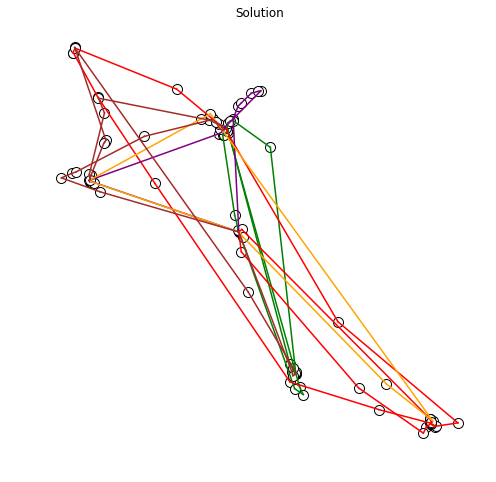

In [30]:
plot_solution(test_state, best_solution)

## 2) Sélection : Tournoi / Mutation : Inversion

In [31]:
population = [construct_initial_solution(test_state) for _ in range(population_size)]
best_solution, best_fitness = genetic_algorithm(test_state, population, population_size, [generations], mutation_rate, selection_method='tournament', mutation_method='inversion')
best_solution = best_solution[0]

print("Best Solution:", best_solution)
print("Fitness Score:", best_fitness)

Best Solution: [0, 59, 17, 55, 54, 12, 44, 103, 49, 38, 82, 91, 37, 73, 20, 62, 101, 94, 69, 46, 0, 79, 90, 66, 84, 58, 41, 99, 5, 70, 42, 57, 61, 89, 40, 2, 81, 28, 72, 36, 63, 21, 0, 27, 1, 68, 10, 93, 85, 19, 24, 98, 7, 83, 45, 48, 9, 0, 16, 71, 80, 18, 65, 56, 60, 67, 25, 86, 0, 104, 97, 102, 14, 87, 96, 3, 23, 52, 78, 39, 35, 88, 15, 50, 47, 106, 6, 77, 8, 74, 29, 33, 64, 4, 53, 30, 34, 51, 92, 32, 95, 31, 100, 26, 75, 76, 43, 22, 11, 13, 105, 107, 0]
Fitness Score: [54.46031367489129]


### Score : 54.46

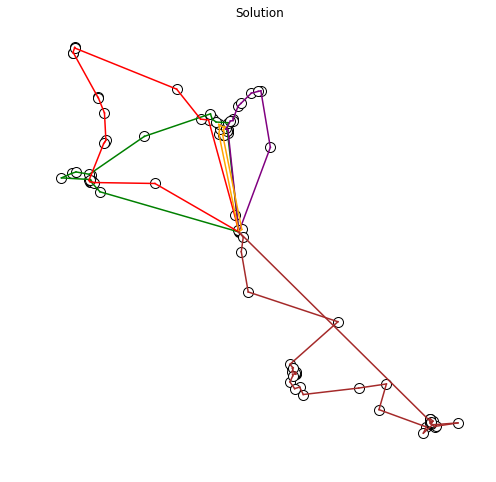

In [33]:
plot_solution(test_state, best_solution)

## 3) Sélection : Roulette / Mutation : Inversion

In [34]:
population = [construct_initial_solution(test_state) for _ in range(population_size)]
best_solution, best_fitness = genetic_algorithm(test_state, population, population_size, [generations], mutation_rate, selection_method='roulette', mutation_method='inversion')
best_solution = best_solution[0]

print("Best Solution:", best_solution)
print("Fitness Score:", best_fitness)

Best Solution: [0, 14, 33, 75, 26, 64, 29, 15, 106, 47, 50, 88, 78, 23, 3, 96, 87, 59, 63, 54, 72, 36, 17, 55, 12, 44, 103, 82, 37, 0, 25, 67, 56, 60, 71, 62, 20, 80, 45, 69, 0, 16, 48, 83, 65, 18, 101, 66, 73, 94, 7, 9, 46, 90, 0, 21, 2, 40, 81, 28, 91, 38, 49, 70, 42, 41, 5, 99, 57, 61, 89, 58, 84, 79, 0, 104, 97, 86, 68, 10, 19, 98, 24, 85, 93, 1, 27, 52, 35, 39, 6, 77, 8, 74, 53, 4, 95, 31, 30, 34, 51, 92, 32, 100, 43, 76, 102, 105, 13, 11, 22, 107, 0]
Fitness Score: [56.80752167395957]


### Score : 56.80

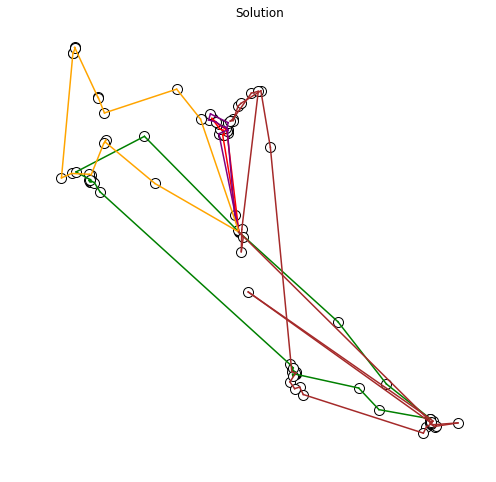

In [36]:
plot_solution(test_state, best_solution)

## 4) Sélection : Roulette / Mutation : Swap

In [37]:
population = [construct_initial_solution(test_state) for _ in range(population_size)]
best_solution, best_fitness = genetic_algorithm(test_state, population, population_size, [generations], mutation_rate, selection_method='roulette', mutation_method='swap')
best_solution = best_solution[0]

print("Best Solution:", best_solution)
print("Fitness Score:", best_fitness)

Best Solution: [0, 67, 7, 98, 24, 19, 10, 68, 1, 92, 22, 11, 105, 95, 30, 32, 51, 34, 53, 74, 8, 47, 96, 97, 79, 90, 16, 18, 25, 86, 0, 104, 14, 100, 107, 13, 39, 59, 49, 38, 82, 55, 17, 12, 54, 63, 45, 46, 0, 21, 91, 28, 103, 44, 72, 36, 81, 56, 60, 80, 101, 37, 57, 61, 89, 2, 40, 0, 83, 69, 65, 62, 66, 84, 73, 48, 9, 26, 75, 76, 0, 42, 70, 41, 58, 20, 71, 94, 85, 93, 27, 78, 88, 35, 50, 15, 106, 77, 6, 52, 23, 3, 87, 99, 5, 102, 29, 64, 4, 31, 43, 33, 0]
Fitness Score: [60.41782669111481]


### Score : 60.41

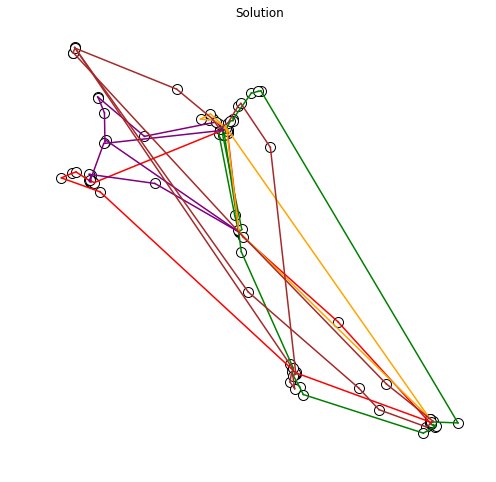

In [38]:
plot_solution(test_state, best_solution)

# **Résultat Final**
Nous obtenons la meilleur solution avec un score de **54.46** et avec comme fonction de sélection : **tournoi** et comme fonction de mutation : **inversion**.

Nous battons ainsi les 2 autres méta-heuristiques précédentes.